In [ ]:
import paper_dataloaders
import paper_models

from seqdata.core import *
from seqdata.models.core import *
from seqdata.learner import *
from seqdata.dataloaders import *
from seqdata.dualrnn import *
from seqdata.hpopt import *
from fastai.basics import *
from fastai.callback.all import *
from seqdata.quaternions import *
from pathlib import Path
from ray import tune
import pickle

from paper_dataloaders import *
from paper_models import *

import ray
from ray import tune
from fastai.basics import *
import pandas as pd
%matplotlib widget

Library "haste_pytorch" not found


# Analyse the table

In [ ]:
ray.init(address='auto') #auto is for attaching to a running local server
# ray.init() #auto is for attaching to a running local server


2024-03-19 15:44:09,501	INFO worker.py:1540 -- Connecting to existing Ray cluster at address: 141.23.125.123:50853...
2024-03-19 15:44:09,510	INFO worker.py:1724 -- Connected to Ray cluster.


RayContext(dashboard_url='', python_version='3.10.11', ray_version='2.9.3', ray_commit='62655e11ed76509b78654b60be67bc59f8f3460a', protocol_version=None)

# Individual Optimization

In [ ]:
experiment_path = Path.home() / 'ray_results/FranSys_P4B_hpopt'
experiments = get_files(experiment_path,'.json').filter(lambda x: 'experiment_state' in x.name)
experiment_list = [tune.ExperimentAnalysis(e,default_metric='_rmse',default_mode='min') for e in experiments]
df = pd.concat([e.dataframe() for e in experiment_list],ignore_index=True).sort_values('_rmse')
trials = list(flatten([exp.trials for exp in experiment_list]))
df['trial'] = df.trial_id.apply(lambda t_id: first(trials, lambda y: y.trial_id == t_id))

2024-03-19 15:57:45,407	WARNING experiment_analysis.py:193 -- Failed to fetch metrics for 880 trial(s):
- learner_optimize_1359e_00242: FileNotFoundError('Could not fetch metrics for learner_optimize_1359e_00242: both result.json and progress.csv were not found at /home/pheenix/ray_results/FranSys_P4B_hpopt/learner_optimize_1359e_00242_242_p_left=0.3059,p_right=0.8608_2024-03-19_06-15-36')
- learner_optimize_1359e_00764: FileNotFoundError('Could not fetch metrics for learner_optimize_1359e_00764: both result.json and progress.csv were not found at /home/pheenix/ray_results/FranSys_P4B_hpopt/learner_optimize_1359e_00764_764_p_left=0.3010,p_right=0.7266_2024-03-19_06-15-44')
- learner_optimize_1359e_00325: FileNotFoundError('Could not fetch metrics for learner_optimize_1359e_00325: both result.json and progress.csv were not found at /home/pheenix/ray_results/FranSys_P4B_hpopt/learner_optimize_1359e_00325_325_p_left=0.2130,p_right=0.8329_2024-03-19_06-15-37')
- learner_optimize_1359e_0035

In [ ]:
df = df[df.training_iteration ==100]

In [ ]:
config = ['config/dl','config/model','config/size']
hyperparameters = ['config/init_pred', 'config/p_left','config/p_right']
important_columns = ['train_loss','valid_loss','_rmse']+hyperparameters+config#+hyperparameter_switches

In [ ]:
best_runs = df.loc[df.groupby(['config/dl','config/size','config/model'])._rmse.idxmin()].sort_values(config,ascending=False)
best_runs[important_columns]

train_loss  valid_loss      _rmse  config/init_pred  config/p_left  \
1428    0.039125    0.024062   0.045014         56.987756       0.313393   
1218    0.038578    0.023126   0.044211         59.822011       0.490293   
1899    0.038840    0.023432   0.044279         50.224417       0.223247   
551     2.715970    8.892944  13.778621        110.934364       0.252640   
971     0.952894    8.800478  13.937150        104.242642       0.227927   
97      1.034291    8.207591  13.101401        131.713125       0.252515   
276     0.136346    0.248923   0.380273        144.885106       0.356949   
802     0.111060    0.245687   0.380156        161.316600       0.443349   
746     0.125299    0.237202   0.371393        133.094173       0.482902   

      config/p_right  config/dl config/model config/size  
1428        0.660935       Ship       nargru       small  
1218        0.746308       Ship       nargru      medium  
1899        0.737833       Ship       nargru       large  
551         0.806648      Robot       nargru       small  
971         0.872221      Robot       nargru      medium  
97          0.772394      Robot       nargru       large  
276         0.704887  Quadrotor       nargru       small  
802         0.785935  Quadrotor       nargru      medium  
746         0.820829  Quadrotor       nargru       large

In [ ]:
top5_per_group = df.groupby(config).apply(lambda x: x.sort_values('_rmse').head(5)).reset_index(drop=True).sort_values(config + ['_rmse'])
top5_per_group[important_columns]

train_loss  valid_loss      _rmse  config/init_pred  config/p_left  \
0     0.125299    0.237202   0.371393        133.094173       0.482902   
1     0.124962    0.238365   0.371451        134.582078       0.417671   
2     0.122314    0.238795   0.371511        196.115360       0.448590   
3     0.122841    0.238877   0.371860        197.828729       0.258697   
4     0.119400    0.239320   0.372508        197.789008       0.469154   
5     0.111060    0.245687   0.380156        161.316600       0.443349   
6     0.111906    0.245189   0.380174        167.442225       0.433262   
7     0.110923    0.245213   0.380508        187.115403       0.429135   
8     0.110772    0.245552   0.380525        187.989129       0.215235   
9     0.112218    0.244731   0.380857        152.486190       0.492143   
10    0.136346    0.248923   0.380273        144.885106       0.356949   
11    0.135171    0.248772   0.381548        175.049115       0.202810   
12    0.136557    0.248972   0.382129        169.301754       0.294522   
13    0.136089    0.248548   0.382229        180.724542       0.393790   
14    0.136349    0.249735   0.382800        185.889544       0.444308   
15    1.034291    8.207591  13.101401        131.713125       0.252515   
16    1.037508    8.501950  13.424297        114.376711       0.341411   
17    1.022555    8.485521  13.432683        110.555730       0.320448   
18    1.045189    8.527979  13.487308        107.014074       0.491103   
19    1.081909    8.590403  13.643314        120.985344       0.309755   
20    0.952894    8.800478  13.937150        104.242642       0.227927   
21    0.963968    8.648617  14.226858        106.788493       0.360070   
22    0.960457    9.123726  14.433495        115.841554       0.438955   
23    0.963698    9.016959  14.435098        133.511666       0.406109   
24    0.966300    9.239278  14.446137        119.324623       0.480620   
25    2.715970    8.892944  13.778621        110.934364       0.252640   
26    2.710365    9.159923  13.949995        106.666637       0.357830   
27    2.734398    9.265235  14.109814        122.904007       0.278267   
28    2.704442    8.959153  14.204129        127.942427       0.499326   
29    2.702355    9.014419  14.289580        109.533921       0.240936   
30    0.038840    0.023432   0.044279         50.224417       0.223247   
31    0.039180    0.023575   0.044462         50.362351       0.470462   
32    0.038932    0.023527   0.044491         48.546486       0.418509   
33    0.038952    0.023422   0.044595         49.787505       0.408064   
34    0.039396    0.023538   0.044634         44.035101       0.365818   
35    0.038578    0.023126   0.044211         59.822011       0.490293   
36    0.038412    0.023230   0.044349         52.395020       0.411646   
37    0.038256    0.023342   0.044428         40.365569       0.240014   
38    0.038251    0.023381   0.044459         30.274100       0.270796   
39    0.038480    0.023287   0.044496         50.083671       0.380864   
40    0.039125    0.024062   0.045014         56.987756       0.313393   
41    0.039379    0.024142   0.045132         54.271587       0.442942   
42    0.039149    0.024194   0.045412         57.299642       0.288825   
43    0.039085    0.024287   0.045601         27.565801       0.252684   
44    0.039037    0.024393   0.045620         46.392230       0.273064   

    config/p_right  config/dl config/model config/size  
0         0.820829  Quadrotor       nargru       large  
1         0.610736  Quadrotor       nargru       large  
2         0.773844  Quadrotor       nargru       large  
3         0.821971  Quadrotor       nargru       large  
4         0.795542  Quadrotor       nargru       large  
5         0.785935  Quadrotor       nargru      medium  
6         0.856169  Quadrotor       nargru      medium  
7         0.608983  Quadrotor       nargru      medium  
8         0.792307  Quadrotor       nargru      medium  
9         0.662589  Quadrotor

# Ablation

In [ ]:
experiment_path = Path.home() / 'hpc_data/ray_results/FranSys_P4B_ablation'
experiments = get_files(experiment_path,'.json').filter(lambda x: 'experiment_state' in x.name)
experiment_list = [tune.ExperimentAnalysis(e,default_metric='_rmse',default_mode='min') for e in experiments]
df = pd.concat([e.dataframe() for e in experiment_list],ignore_index=True).sort_values('_rmse')
trials = list(flatten([exp.trials for exp in experiment_list]))
df['trial'] = df.trial_id.apply(lambda t_id: first(trials, lambda y: y.trial_id == t_id))

2024-03-18 14:31:17,127	WARNING experiment_analysis.py:193 -- Failed to fetch metrics for 44 trial(s):
- learner_optimize_079b7_01778: FileNotFoundError('Could not fetch metrics for learner_optimize_079b7_01778: both result.json and progress.csv were not found at /home/pheenix/hpc_data/ray_results/FranSys_P4B_ablation/learner_optimize_079b7_01778_1778_dl=Ship,init_pred=120,p_left=0.2000,p_right=0.9000_2024-03-18_11-53-26')
- learner_optimize_079b7_01779: FileNotFoundError('Could not fetch metrics for learner_optimize_079b7_01779: both result.json and progress.csv were not found at /home/pheenix/hpc_data/ray_results/FranSys_P4B_ablation/learner_optimize_079b7_01779_1779_dl=Quadrotor,init_pred=150,p_left=0.2000,p_right=0.9000_2024-03-18_11-54-34')
- learner_optimize_079b7_01780: FileNotFoundError('Could not fetch metrics for learner_optimize_079b7_01780: both result.json and progress.csv were not found at /home/pheenix/hpc_data/ray_results/FranSys_P4B_ablation/learner_optimize_079b7_0178

In [ ]:
df = df[df.training_iteration ==100]

In [ ]:
df.keys()

Index(['train_loss', 'valid_loss', '_rmse', 'timestamp', 'checkpoint_dir_name',
       'should_checkpoint', 'done', 'training_iteration', 'trial_id', 'date',
       'time_this_iter_s', 'time_total_s', 'pid', 'hostname', 'node_ip',
       'time_since_restore', 'iterations_since_restore', 'config/dl',
       'config/init_pred', 'config/p_left', 'config/p_right', 'config/model',
       'config/size', 'config/pred_sz', 'config/schedule_pred',
       'config/pct_start', 'config/n_epoch', 'config/wd', 'config/tsr_alpha',
       'config/tsr_beta', 'config/hidden_p', 'config/has_hidden_p',
       'config/weight_p', 'config/has_weight_p', 'config/opt_beta',
       'config/lr', 'config/create_lrn', 'config/dls', 'config/fit_method',
       'logdir', 'trial'],
      dtype='object')

In [ ]:
config = ['config/dl']
hyperparameters = ['config/init_pred', 'config/p_left','config/p_right']
group = config + hyperparameters
important_columns = ['_rmse']+hyperparameters+config#+hyperparameter_switches

In [ ]:
df[important_columns]

_rmse  config/init_pred  config/p_left  config/p_right config/dl
1505   0.044792                90            0.5             0.6      Ship
188    0.045024                60            0.4             0.6      Ship
869    0.045106                30            0.0             0.7      Ship
911    0.045595                90            0.2             0.7      Ship
326    0.045598                 1            0.0             0.8      Ship
...         ...               ...            ...             ...       ...
598   19.170397                30            0.3             1.0     Robot
1624  19.333189                30            0.0             0.8     Robot
31    19.448679                30            0.2             0.5     Robot
1282  19.517843                30            0.5             1.0     Robot
634   20.650654                30            0.5             1.0     Robot

[1737 rows x 5 columns]

In [ ]:
best_runs = df.loc[df.groupby(group)._rmse.idxmin()].sort_values(config,ascending=False)
best_runs[important_columns]

_rmse  config/init_pred  config/p_left  config/p_right  config/dl
647   0.046862               150            0.5             1.0       Ship
851   0.047246                30            0.5             0.6       Ship
43    0.046590                60            0.1             0.5       Ship
1196  0.046558                60            0.0             1.0       Ship
440   0.046854                60            0.0             0.9       Ship
...        ...               ...            ...             ...        ...
423   0.451117                90            0.5             0.8  Quadrotor
963   0.449083                90            0.5             0.7  Quadrotor
1503  0.448749                90            0.5             0.6  Quadrotor
747   0.447995                90            0.5             0.5  Quadrotor
648   0.437045                 1            0.0             0.5  Quadrotor

[648 rows x 5 columns]

In [ ]:
df_med = df.groupby(group,as_index=False)._rmse.median()
df_med.to_pickle('df_ablation.p')

In [ ]:
best_runs = df_med.loc[df_med.groupby(config)._rmse.idxmin()].sort_values(config,ascending=False)
best_runs[important_columns]

_rmse  config/init_pred  config/p_left  config/p_right  config/dl
530   0.046007                60            0.4             0.7       Ship
374  14.609298               120            0.2             0.7      Robot
203   0.384121               150            0.3             1.0  Quadrotor

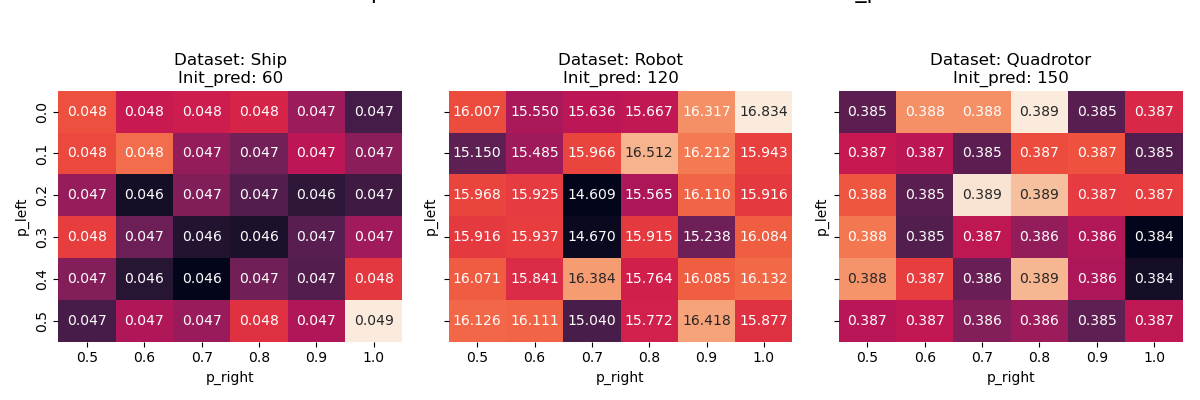

In [ ]:
# Grouping by the specified columns and calculating the median RMSE
df_med = df.groupby(["config/dl", "config/init_pred", "config/p_left", "config/p_right"], as_index=False)._rmse.median()

# Creating a list of unique datasets and init_pred values for subplots
datasets = df['config/dl'].unique()
init_preds = df['config/init_pred'].unique()

# Sorting the init_preds for consistent layout
init_preds.sort()

# Preparing for subplots
fig, axes = plt.subplots(1, len(datasets), figsize=(len(datasets)*4, 4), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.5, wspace=0.7)

for idx,row in best_runs.reset_index().iterrows():
    # Filtering the dataframe for each subplot based on current dataset and init_pred
    dataset = row['config/dl']
    init_pred = row['config/init_pred']
    df_sf = df_med[(df_med['config/dl'] == dataset) & (df_med['config/init_pred'] == init_pred)]

    if df_sf.empty:
        continue

    # Pivoting the data for the heatmap
    heatmap_data_agg = df_sf.pivot("config/p_left", "config/p_right", "_rmse")

    # Plotting the heatmap
    sns.heatmap(heatmap_data_agg, annot=True, fmt=".3f", ax=axes[idx], cbar=False)
    axes[idx].set_title(f"Dataset: {dataset}\nInit_pred: {init_pred}")
    axes[idx].set_xlabel('p_right')
    axes[idx].set_ylabel('p_left')

plt.suptitle("Heatmap of Median RMSE for Each Dataset and init_pred", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

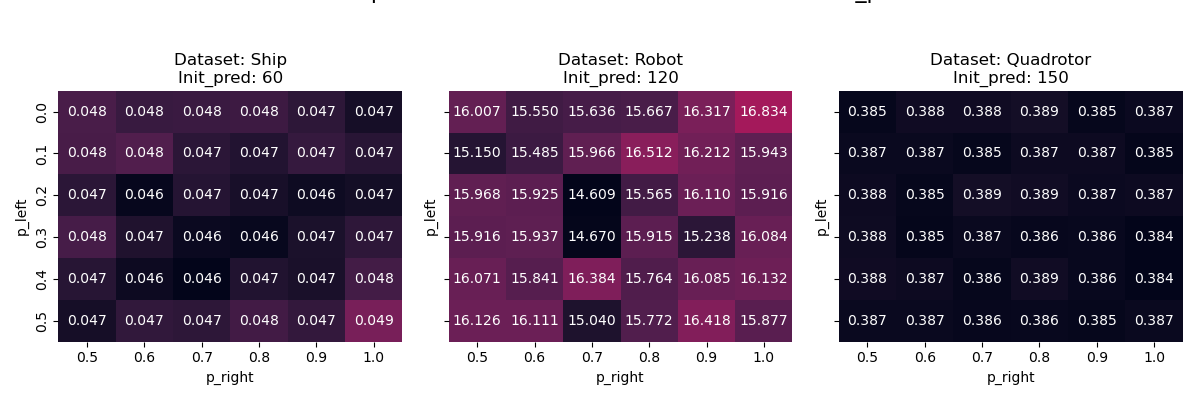

In [ ]:
# Grouping by the specified columns and calculating the median RMSE
df_med = df.groupby(["config/dl", "config/init_pred", "config/p_left", "config/p_right"], as_index=False)._rmse.median()

# Creating a list of unique datasets and init_pred values for subplots
datasets = df['config/dl'].unique()
init_preds = df['config/init_pred'].unique()

# Sorting the init_preds for consistent layout
init_preds.sort()

# Preparing for subplots
fig, axes = plt.subplots(1, len(datasets), figsize=(len(datasets)*4, 4), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.5, wspace=0.7)

for idx,row in best_runs.reset_index().iterrows():
    # Filtering the dataframe for each subplot based on current dataset and init_pred
    dataset = row['config/dl']
    init_pred = row['config/init_pred']
    df_sf = df_med[(df_med['config/dl'] == dataset) & (df_med['config/init_pred'] == init_pred)]

    if df_sf.empty:
        continue

    # Pivoting the data for the heatmap
    heatmap_data_agg = df_sf.pivot("config/p_left", "config/p_right", "_rmse")

    # Plotting the heatmap
    sns.heatmap(heatmap_data_agg, annot=True, fmt=".3f", ax=axes[idx], cbar=False,
                vmin=df_med[(df_med['config/dl'] == dataset)]._rmse.min(),
                vmax=df_med[(df_med['config/dl'] == dataset)]._rmse.max())
    axes[idx].set_title(f"Dataset: {dataset}\nInit_pred: {init_pred}")
    axes[idx].set_xlabel('p_right')
    axes[idx].set_ylabel('p_left')

plt.suptitle("Heatmap of Median RMSE for Each Dataset and init_pred", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

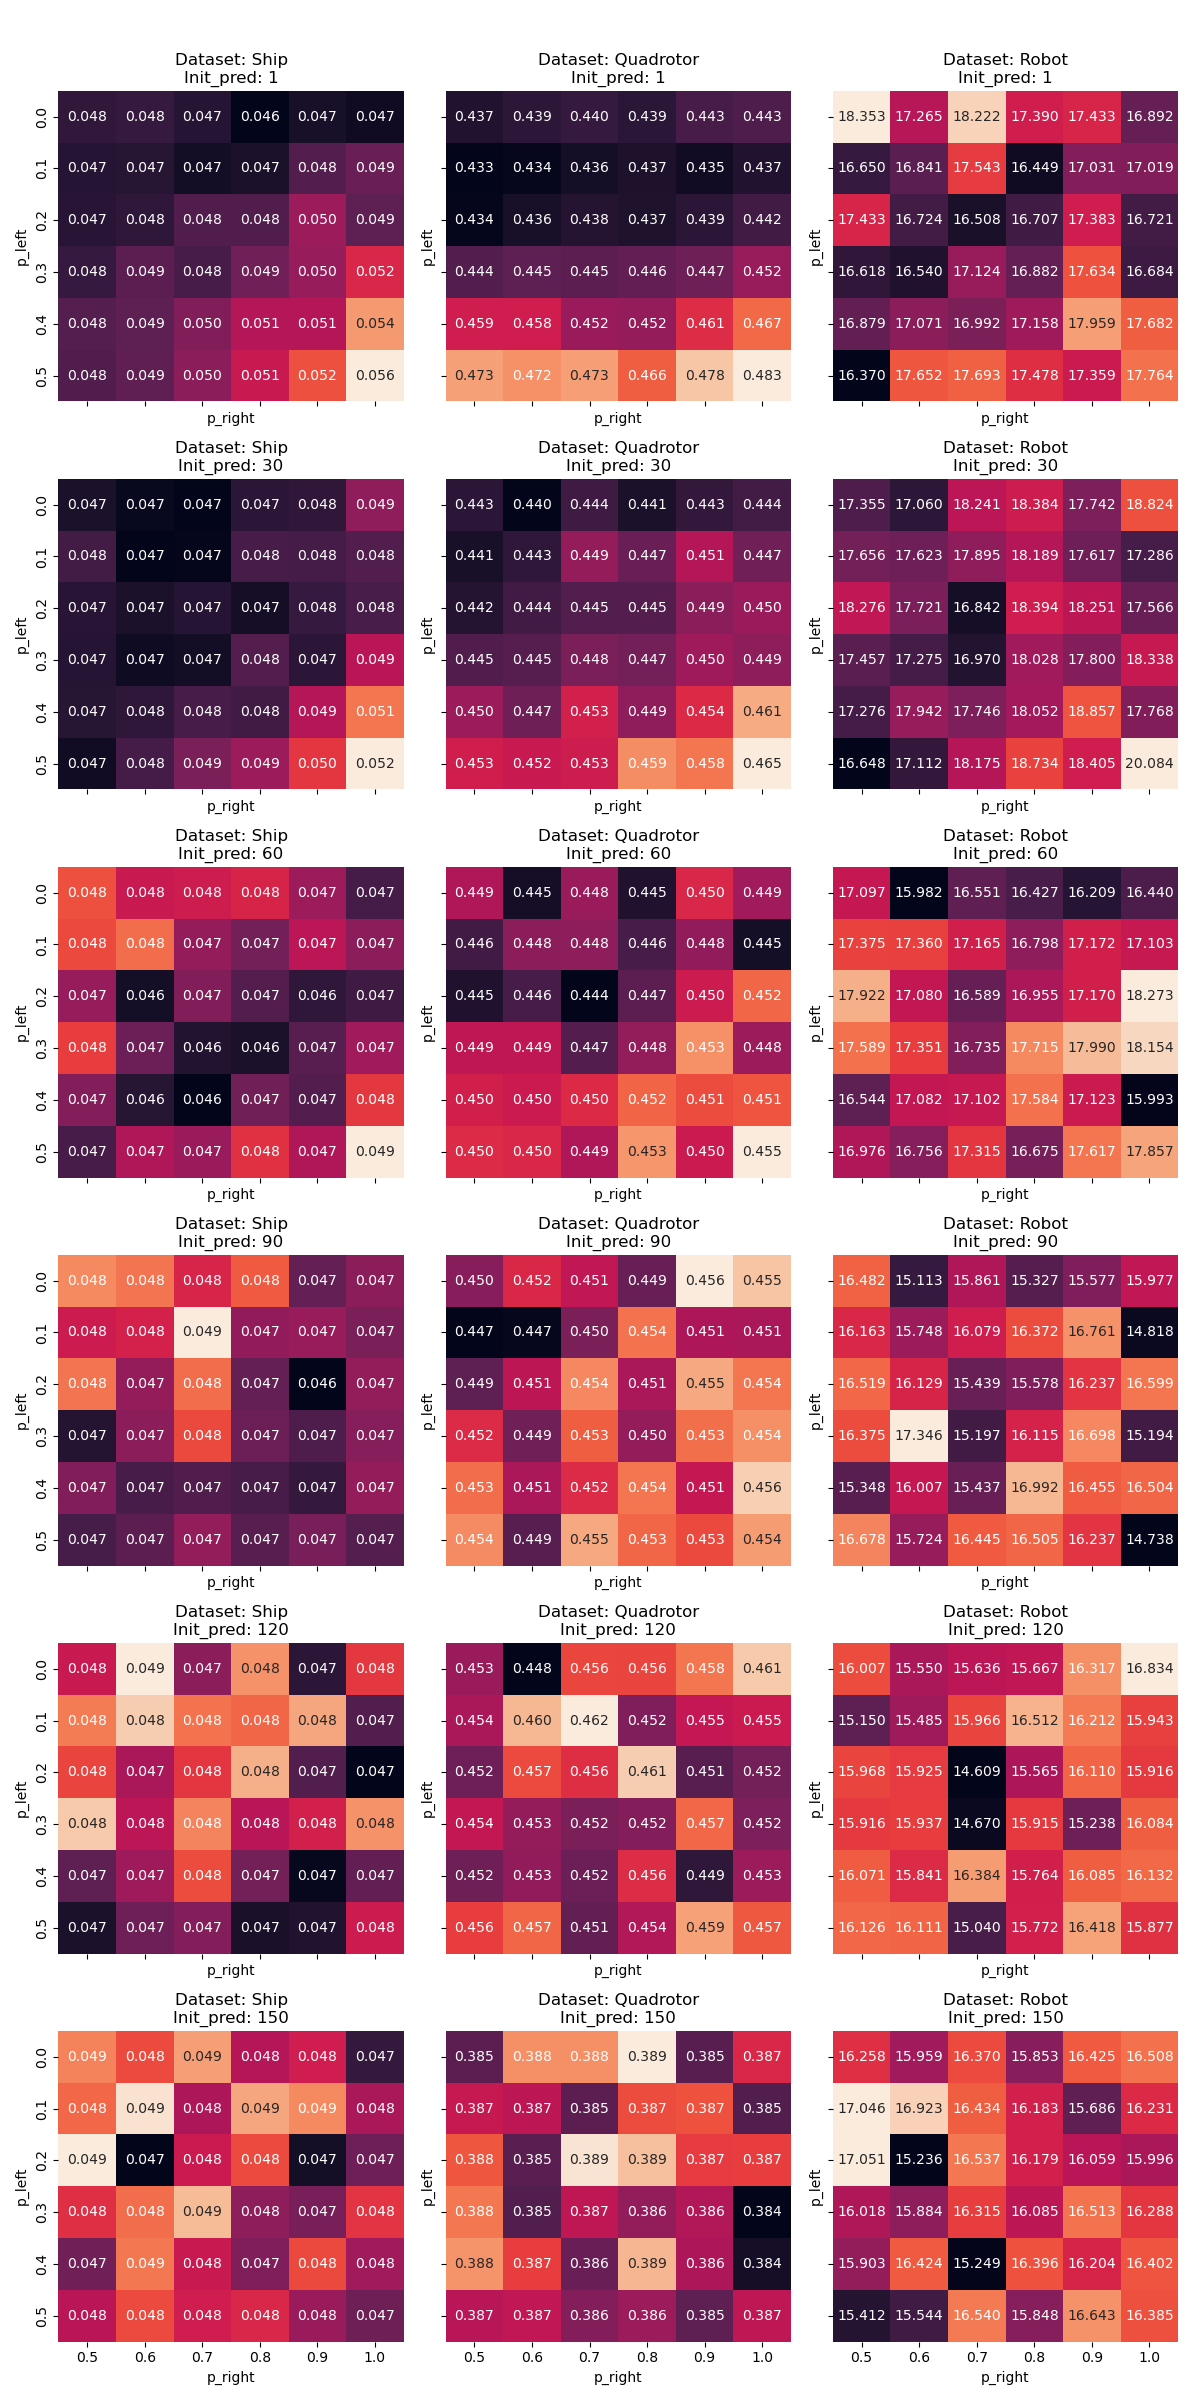

In [ ]:
# Grouping by the specified columns and calculating the median RMSE
df_med = df.groupby(["config/dl", "config/init_pred", "config/p_left", "config/p_right"], as_index=False)._rmse.median()

# Creating a list of unique datasets and init_pred values for subplots
datasets = df['config/dl'].unique()
init_preds = df['config/init_pred'].unique()

# Sorting the init_preds for consistent layout
init_preds.sort()

# Preparing for subplots
fig, axes = plt.subplots(len(init_preds), len(datasets), figsize=(len(datasets)*4, len(init_preds)*4), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.5, wspace=0.7)

for i, init_pred in enumerate(init_preds):
    for j, dataset in enumerate(datasets):
        # Filtering the dataframe for each subplot based on current dataset and init_pred
        df_sf = df_med[(df_med['config/dl'] == dataset) & (df_med['config/init_pred'] == init_pred)]

        if df_sf.empty:
            continue

        # Pivoting the data for the heatmap
        heatmap_data_agg = df_sf.pivot("config/p_left", "config/p_right", "_rmse")

        # Plotting the heatmap
        sns.heatmap(heatmap_data_agg, annot=True, fmt=".3f", ax=axes[i, j], cbar=False)
        axes[i, j].set_title(f"Dataset: {dataset}\nInit_pred: {init_pred}")
        axes[i, j].set_xlabel('p_right')
        axes[i, j].set_ylabel('p_left')

plt.suptitle("Heatmap of Median RMSE for Each Dataset and init_pred", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

# Export Hyperparameters

In [ ]:
keys_config = [x for x in best_runs.keys() if 'config' in x]
# hpopt_configs = {tuple(row[config]): dict(row[hyperparameters+config]) for (idx,row) in best_runs.iterrows()}
hpopt_configs = {tuple(row[config]): {k[7:]:dict(row[hyperparameters])[k] for k in dict(row[hyperparameters])} for (idx,row) in best_runs.iterrows()}
hpopt_configs

{('Ship', 'nargru', 'small'): {'init_pred': 56.98775579637339,
  'p_left': 0.3133930620314255,
  'p_right': 0.6609354848616203},
 ('Ship', 'nargru', 'medium'): {'init_pred': 59.8220111774565,
  'p_left': 0.4902931625906382,
  'p_right': 0.7463081785840546},
 ('Ship', 'nargru', 'large'): {'init_pred': 50.22441710858534,
  'p_left': 0.22324682347334796,
  'p_right': 0.7378327145357202},
 ('Robot', 'nargru', 'small'): {'init_pred': 110.93436378540837,
  'p_left': 0.2526400961223403,
  'p_right': 0.8066478200443761},
 ('Robot', 'nargru', 'medium'): {'init_pred': 104.24264249172703,
  'p_left': 0.22792725016055682,
  'p_right': 0.8722206292642242},
 ('Robot', 'nargru', 'large'): {'init_pred': 131.7131246511381,
  'p_left': 0.25251466557024105,
  'p_right': 0.7723938154101723},
 ('Quadrotor', 'nargru', 'small'): {'init_pred': 144.8851057166747,
  'p_left': 0.356949312554074,
  'p_right': 0.7048867686337545},
 ('Quadrotor', 'nargru', 'medium'): {'init_pred': 161.3165998008092,
  'p_left': 0.4

In [ ]:
import pickle
pickle.dump(hpopt_configs, open('configs_4B.p', 'wb') )